0
1
2
3
4
5


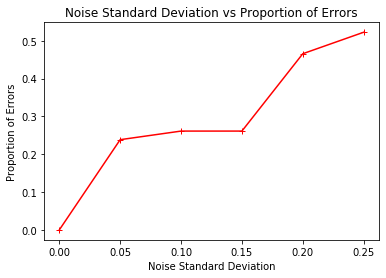

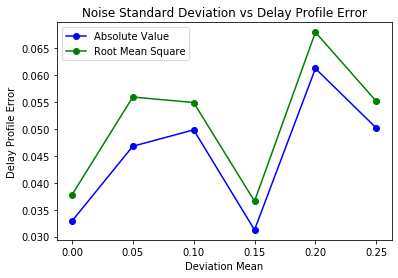

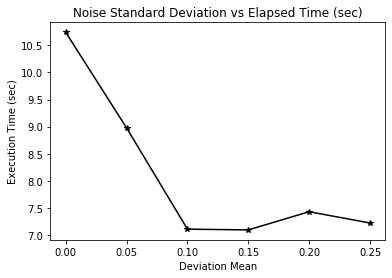

In [2]:

#DELAY PROFILE - 30 delay 1's, 39 delay 2's and 31 dealy 3's gives a delay profile of .3,.39, .31.
#This is obtained by dividing the number of each delays by the total number T
#The actual delay profile is 1/3, 1/3, 1/3.  The mean absolute error (abs(.3-1/3)+abs(.39-1/3)+abs(.31-1/3))/3
#Root mean squared error- remove abs and square, then avg, then squareroot

#Parameters: length of delayProb(uniform), vary commit prob, and vary noise(both) with surface plot
#Benchmark meancommit = 1 probcommit = 1 noise mean = 0 noise std = .05, delayProb len = 6, T = 10000 at least
#probcommit from .05 to 1
#noise_mean from -.2 to .2
#noise std from 0 to .25
#delayProb length up to 10 (possibly)
#Use this on different delay probabilities
#plot each


from numpy import *
from matplotlib.pyplot import *

import time


T = 100
mean_commit = 1
prob_commit = 1
noise_mean = 0
noise_std = arange(0,.3,.05)
delayProb = array([1,2,3,3,2,1])
delayProb = delayProb/sum(delayProb)

def budgetCode(T,mean_commit,prob_commit,noise_mean,noise_std,delayProb):
    delayProb = delayProb/sum(delayProb)
    nDay = len(delayProb)
    obsCom = random.exponential(scale=mean_commit,size=T)
    binomVec = random.binomial(1,prob_commit,size=T)
    obsCom = obsCom*binomVec
    actDelay = random.choice(arange(1,nDay+1),T,p=delayProb)
    actDelay = actDelay*binomVec # No delay if there is no commit
    obsObl = list(random.normal(loc=noise_mean,scale=noise_std,size=T+nDay))
    for t in range(T):
        obsObl[t+actDelay[t]] += obsCom[t]
    del (obsObl[-nDay:])
    # =============================================================================
    # obsObl = array([1,9,2,3,5,6,7,3,6,1,8]) # Need array of obligations (observed)
    # obsCom = array([1,0,4,2,9,1,3,3,5,6,7]) # Need array of commits (observed)
    # =============================================================================
    
    #nDay = 6  #number of days within which commits obligate
    nStateMax = 2**(nDay-1) #number of possible states  
    srcVal = zeros(nStateMax) # these are values for each source state
    srcCom = [[0] for i in range(nStateMax)] # Need record of when obligations commit for each possible history,
    # for source (array of arrays)
    
    binState = [] #initialize binary states list
    for jS in range(nStateMax): # One-time loop to generate binary representation of states
        # Note the '[3,:]' in the following removes '0x1' from each binary string
        binState.append(array([int(d) for d in str(bin(2*nStateMax+2*jS+1))[3:]]))
    
    # Time loop to compute commits that obligate at each time
    for t in range(1,len(obsObl)):  # loop through all obligations (start at index nDay)
        nState = min(2**(t-1),nStateMax) # Number of states where potential obligations are committed
        tgtCom = [[] for i in range(nStateMax)] # Need record of when obligations commit for each possible history,
                                                # for target (array of arrays)
        tgtVal = zeros(nStateMax)-1.E10        # these are values for each target state
        possVecBool = zeros(nDay)
        possVecBool[max(0,nDay-t):nDay] = obsCom[max(0,t-nDay):t]>0  # Compute log, vec.for nonzero possible obligates possVec
        # Loop through source states to compute all possible obligations @ time t
        for jS in range(nState):               # Looping over candidate source states
            if srcVal[jS] > -1E8:             # Pass by if source is impossible
                # Identify possible commits 
                possCommBool = (binState[jS] == 1)*possVecBool > 0
                indVec = where(possCommBool)[0] # indVec = indices of nonzero entries of binState[jS] use where()
                nT = 2**len(indVec) #Number of target states
                powVec = 2**((nDay-1)-indVec) # powVec = Raise these entries to appropriate powers of 2 (array)
                #loop over all possible obligations for current unobligated commits
                for jT in range(nT): 
                    if nT>1: # If there's a possibility of obligation, evaluate impact on value
                        tBin = array([bool(int(d)) for d in str(bin(nT+jT))[3:]]) # tBin  = Convert jT to binary vector
                        comObl = (indVec[tBin])  # Use tBin and indVec to identify commits that are obligated
                        tempTrans = (t-nDay+comObl) # actual indices of commits that are obligating
                        transVal = -(sum(obsCom[tempTrans])-obsObl[t])**2 # Use this to get the transition value (log likelihood)
                        tempVal = transVal+srcVal[jS] # Add transition value to srcVal 
                        tempState = (jS*2+1)-sum(powVec[tBin]) # Use source and powVec to identify target state
                        tgtState = (tempState%nStateMax) # Drop off the commit that's too old          
                        if tempVal > tgtVal[tgtState]: # Compare result with tgtVal
                            tgtVal[tgtState] = tempVal # If better, than replace tgtVal
                            tgtCom[tgtState] = srcCom[jS]+[sum(powVec[tBin])] # Augment history with new obligations
                    else: #No possibility of obligation, move the state along
                        tempVal = srcVal[jS]
                        tgtState = (jS*2+1)%nStateMax
                        if tempVal > tgtVal[tgtState]: # Compare result with tgtVal
                            tgtVal[tgtState] = tempVal # If better, than replace tgtVal
                            tgtCom[tgtState] = srcCom[jS]+[0] # Augment history with new obligations
    
        # Note that tgtCom is a list of lists--each in-list gives a matching of
        # commits to obligations, in encoded form. The index of each in-list 
        # in the out-list specifies which current state is associated with the 
        # matching represented by the in-list. The elements of the in-list 
        # are integers, where the t'th integer tells which commits obligate at time t.
        # This integer is interpreted in the final loop below.
        srcCom=tgtCom # Update source commit history to the next stage in the trellis
        srcVal=tgtVal  # Update source value to the next stage in the trellis
    optCom = srcCom[argmax(srcVal)] # select overall optimal solution
    
    # Reconstruction of optimal schedule from encoded commit-to-obligate matching
    optDelay = zeros(len(obsCom),dtype=int) # Array holds obligation times for each commit
    for t in range(1,len(optCom)):
        # optCom[t] tells which commits obligated at t.  The following 
        # code interprets this and turns into delay information.
        tempBin = array([bool(int(d)) for d in str(bin(optCom[t]+2**nDay))[3:]])
        tmpDelays = nDay - where(tempBin)[0]
        optDelay[t-tmpDelays] = tmpDelays
    optDelay *= (obsCom>0)
    nCommit = count_nonzero(actDelay[:-nDay*2])
    nRight = count_nonzero(optDelay[:-nDay*2]-actDelay[:-nDay*2])
    print(L)
    return optDelay,nRight,nCommit
elapTime = zeros(len(noise_std))
optDelayVec = zeros(len(noise_std))
optDelayVec2 = zeros(len(noise_std))
nRightVec = zeros(len(noise_std))
nCommitVec= zeros(len(noise_std))
for L in range(len(noise_std)):
    start_time = time.time()
    optDelay,nRight,nCommit = budgetCode(T,mean_commit,prob_commit,noise_mean,noise_std[L],delayProb)
    binVec = bincount(optDelay)[1:]
    optDelayVec[L] = mean(abs(binVec/sum(binVec) - delayProb))
    optDelayVec2[L] = sqrt(((binVec/sum(binVec) - delayProb) ** 2).mean())
    nRightVec[L] = nRight/nCommit
    elapTime[L] = time.time() - start_time

figure(2)
plot(noise_std,nRightVec,marker = "+",color = "red")
title("Noise Standard Deviation vs Proportion of Errors")
xlabel("Noise Standard Deviation")
ylabel("Proportion of Errors")
savefig('stdnoisevsright.png')

figure(3)
plot(noise_std,optDelayVec,marker = "o",color = "blue",label = "Absolute Value")
plot(noise_std,optDelayVec2,marker = "o",color = "green",label = "Root Mean Square")
legend()
title("Noise Standard Deviation vs Delay Profile Error")
xlabel("Deviation Mean")
ylabel("Delay Profile Error")
savefig('stdnoisevsdelay.png')

figure(4)
plot(noise_std,elapTime,marker = "*",color = "black")
title("Noise Standard Deviation vs Elapsed Time (sec)")
xlabel("Deviation Mean")
ylabel("Execution Time (sec)")
savefig('stdnoisevstime.png')

show() 
#print(nRight,"incorrect out of ",nCommit,"commits")
#figure(1)
#clf()
#hist(optDelay[:-nDay*2],bins=range(nDay+2))

